
# How to use `xarray.DataTree` with hierarchical data


## Overview: 

This notebook will demonstrate how to use `xarray.DataTree` with [_GPM IMERG Final Precipitation L3 Half Hourly 0.1 degree x 0.1 degree V07 (GPM_3IMERGHH_07)_](https://disc.gsfc.nasa.gov/datasets/GPM_3IMERGHH_07/summary) and use xarray's plotting capabilities to plot precipitation in the Gulf of Mexico during Hurricane Ida. GPM_3IMERGHH_07 is a L3 gridded product with a group hierarchical structure.

In [ ]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from xarray import open_datatree
from metpy.plots import ctables

### Opening the dataset with `open_datatree()`

In [ ]:
gpm_imerghh_7 = open_datatree('~/Downloads/3B-HHR.MS.MRG.3IMERG.20210829-S073000-E075959.0450.V07B.HDF5', engine='h5netcdf')
gpm_imerghh_7

### List all of the groups with `.groups`

In [ ]:
gpm_imerghh_7.groups

### Accessing variables in a nested groups
Nested variables and groups can be accessed with either dict-like syntax or method based syntax.

In [ ]:
gpm_imerghh_7['/Grid']

# Returns only the data contained in the "/Grid" group

In [ ]:
gpm_imerghh_7['/Grid/precipitation']

In [ ]:
gpm_imerghh_7.Grid.precipitation

### Get the parent and child nodes from a group

In [ ]:
gpm_imerghh_7['/Grid/Intermediate'].parent

In [ ]:
gpm_imerghh_7.Grid.children

### `Xarray.DataTree` objects and `xarray.Dataset` objects have the same key properties like:

- `dims`: a dictionary mapping of dimension names to lengths, for the variables in a node, and a node’s ancestors.

- `data_vars`: a dict-like container of DataArrays corresponding to variables in a node.

- `coords`: another dict-like container of DataArrays, corresponding to coordinate variables in a node, and a node’s ancestors.

- `attrs`: dict with metadata relevant to data in a node.

With `DataTree` you can get these properties at any of the nodes (groups) they are defined in.

In [ ]:
gpm_imerghh_7.dims
# Note there are no dimensions, coordinates, or data variables defined at the root node

In [ ]:
gpm_imerghh_7.attrs

In [ ]:
gpm_imerghh_7['/Grid'].dims

In [ ]:
gpm_imerghh_7['/Grid/Intermediate'].dims

In [ ]:
gpm_imerghh_7['/Grid/Intermediate'].data_vars

### Plotting precipitation data with DataTree
Xarray’s plotting capabilities are centered around DataArray objects. To plot DataTree objects we access their relevant DataArrays in this case, `gpm_imerghh_7['/Grid/precipitation']`. 

We use the `.where()` method to get a subset of precipitation data over the Gulf of Mexico.

In [ ]:
precipitation_subset = gpm_imerghh_7['/Grid/precipitation'].where(
    (gpm_imerghh_7['/Grid/precipitation'].lat >= 20) & (gpm_imerghh_7['/Grid/precipitation'].lat <= 35) & 
    (gpm_imerghh_7['/Grid/precipitation'].lon >= -110) & (gpm_imerghh_7['/Grid/precipitation'].lon <= -78), drop=True
)

### Data masking
We add a data mask to the precipitation values that are zero.

In [ ]:
precipitation_subset_mask = precipitation_subset.where(precipitation_subset > 0.0)

### Add a custom precipitation color map from [metpy](https://unidata.github.io/MetPy/latest/api/generated/metpy.plots.ctables.html)

In [ ]:
clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40,
         50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 750]
norm, cmap = ctables.registry.get_with_boundaries('precipitation', clevs)
cmap

### Plot the data with `.plot()`
Note since this data is two-dimensional it calls `xarray.plot.pcolormesh()` by default with just the `.plot()` method.

Text(0.5, 1.0, 'Half-hourly precipitation rate in the Gulf of Mexico on August 29, 2021 at 07:30')

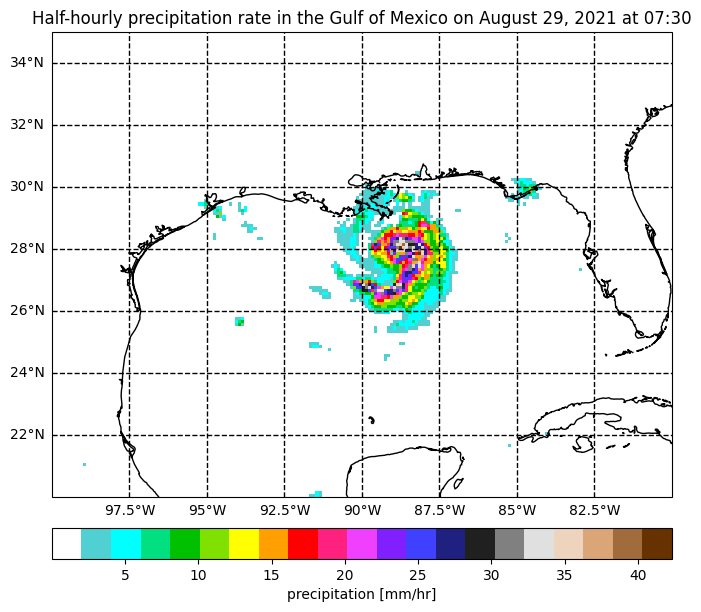

In [23]:
# Set the figure size, projection, extent and grid lines to the plot
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-100, -80, 20, 35])
ax.coastlines()
gl = ax.gridlines(draw_labels=True, linewidth=1, color='black', linestyle='--')
gl.right_labels = False
gl.top_labels = False

# Get the minimum and maximum values in the array
min =  precipitation_subset_mask.min()
max = precipitation_subset_mask.max()

# Plot the precipitation data
precipitation_subset_mask[0].plot(x="lon", y="lat",
                                  ax=ax, cmap=cmap,
                                  cbar_kwargs={"orientation":"horizontal", "pad": 0.05},
                                  vmin=min, vmax=max)

plt.title('Half-hourly precipitation rate in the Gulf of Mexico on August 29, 2021 at 07:30')